In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
class ToTensor:
    def __call__(self, x):
        return torch.from_numpy(x).float()

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001
size = 28 # Options: 28, 64

info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
task = info['task']

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=transforms.Compose([ToTensor()]), download=download, size=size)
#train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
info

{'python_class': 'OrganMNIST3D',
 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/organmnist3d.npz?download=1',
 'MD5': 'a0c5a1ff56af4f155c46d46fbb45a2fe',
 'url_64': 'https://zenodo.org/records/10519652/files/organmnist3d_64.npz?download=1',
 'MD5_64': '58a2205adf14a9d0a189cb06dc78bf10',
 'task': 'multi-class',
 'label': {'0': 'liver',
  '1': 'kidney-right',
  '2': 'kidney-left',
  '3': 'femur-right',
  '4': 'femur-left',
  '5': 'bladder',
  '6': 'heart',
  '7': 'lung-right',
  '8': 'lung-left',
  '9

In [5]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([1, 28, 28, 28]) (1,)


In [6]:
x.dtype

torch.float32

In [7]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [8]:
frames = train_dataset.montage(length=1, save_folder="/home/arthur/")
frames[10]


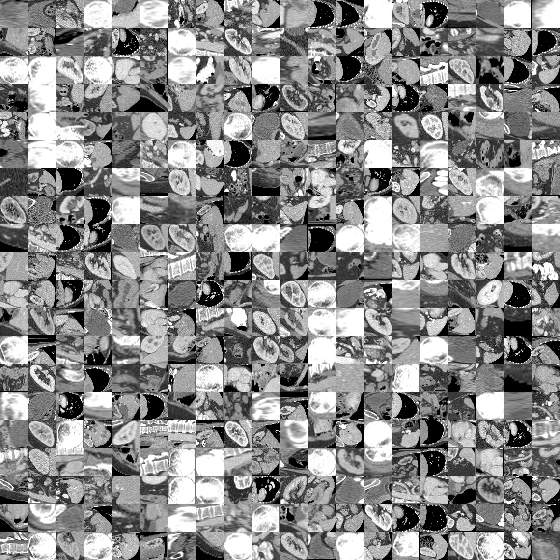

In [9]:
frames = train_dataset.montage(length=20, save_folder="/home/arthur/")

frames[10]

In [10]:
import torch.nn as nn
from torch.nn.functional import relu

In [64]:
class UNET3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, 2)
        self.conv2 = nn.Conv3d(32, 64, 2)
        self.max1 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(64, 128, 2)
        self.conv4 = nn.Conv3d(128, 256, 2)
        self.conv5 = nn.Conv3d(256, 256, 2)

        self.dense1 = nn.Linear(256*4*4*4, 128)
        self.dense2 = nn.Linear(128, 11)
    
    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.max1(relu(self.conv2(x)))
        x = relu(self.conv3(x))
        x = self.max1(relu(self.conv4(x)))
        x = self.conv5(x)
        x = self.dense1(x.view(x.shape[0], -1))
        x = self.dense2(x)
        return x
    
model = UNET3D().to('cuda')

In [89]:
y.shape

torch.Size([75])

In [109]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10


for i in range(epochs):
    model.train()
    print(f"Epoca: {i+1}/{epochs}")
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.squeeze().to(device)
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        print(loss.item())


Epoca: 1/10
0.3943819999694824
1.9651577472686768
0.9393180012702942
0.5619904398918152
0.5620967745780945
0.5577508807182312
0.48995333909988403
0.3559359610080719
Epoca: 2/10
0.5453413128852844
0.6556903719902039
0.6592069268226624
0.48267143964767456
0.6057893633842468
0.5555804967880249
0.3176112174987793
0.36697083711624146
Epoca: 3/10
0.3742143511772156
0.4036475121974945
0.39537960290908813
0.4467123746871948
0.36172452569007874
0.2794472277164459
0.3804241418838501
0.2861537039279938
Epoca: 4/10
0.3671107888221741
0.38586097955703735
0.3615427613258362
0.2676447033882141
0.19740259647369385
0.2503780126571655
0.29181116819381714
0.3105427920818329
Epoca: 5/10
0.28408750891685486
0.16471204161643982
0.19488270580768585
0.22263845801353455
0.28974398970603943
0.23616354167461395
0.1756565272808075
0.4277990758419037
Epoca: 6/10
0.14124491810798645
0.31676435470581055
0.18597978353500366
0.19232316315174103
0.15758110582828522
0.18920458853244781
0.1351923644542694
0.2887916266918

In [131]:
val_dataset = DataClass(split='val', transform=transforms.Compose([ToTensor()]), download=download, size=size)
# encapsulate data into dataloader form
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
with torch.no_grad():
    model.eval()
    accuracies = []
    for x,y in val_loader:
        x, y = x.to(device), y.squeeze().to(device)
        output = torch.argmax(model(x), dim=1)
        correct = torch.sum(output == y)
        accuracies.append(correct/len(x))
    accuracies = torch.Tensor(accuracies)
    print(f"Val Accuracy: {accuracies.mean():.2f}%")

Val Accuracy: 0.96%


In [ ]:
test_dataset = DataClass(split='test', transform=transforms.Compose([ToTensor()]), download=download, size=size)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

with torch.no_grad():
    model.eval()
    accuracies = []
    for x,y in test_loader:
        x, y = x.to(device), y.squeeze().to(device)
        output = torch.argmax(model(x), dim=1)
        correct = torch.sum(output == y)
        accuracies.append(correct/len(x))
    accuracies = torch.Tensor(accuracies)
    print(f"Val Accuracy: {accuracies.mean():.2f}%")

Val Accuracy: 0.83%
